In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
import numpy as np
import matplotlib.pylab as plt

from future_features import tape
from mapper import Mapper

from testsuite import *

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __

In [2]:
N = 10000
Ntest = 10000

n_features = 2
n_components = 4
n_restarts = 1
n_datasets = 1
deviations = np.logspace(-3,1,5, dtype='float32')

In [3]:
deviation = deviations[-1] # take a large-variance prior on the cluster means, i.e. spread-out clusters, i.e. high snr

In [4]:
mixture_component_covariances_cholesky_df = .1
mixture_component_covariances_cholesky_scale_tril = (1./(mixture_component_covariances_cholesky_df - n_features - 1.))*tf.eye(n_features)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 69429.890625
  Number of iterations: 34
  Number of functions evaluations: 49
69429.89
6.855558
6.871101


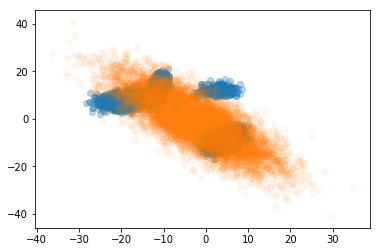

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 47020.316406
  Number of iterations: 106
  Number of functions evaluations: 160
47020.316
4.6773376
4.66162


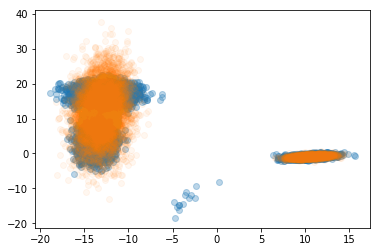

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62246.265625
  Number of iterations: 40
  Number of functions evaluations: 55
62246.266
6.1743083
6.177568


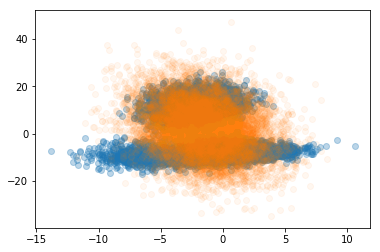

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 65414.722656
  Number of iterations: 32
  Number of functions evaluations: 37
65414.723
6.4234853
6.414941


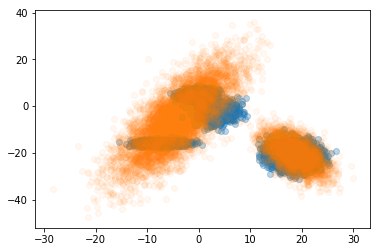

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 65006.597656
  Number of iterations: 82
  Number of functions evaluations: 104
65006.598
6.3572607
6.360517


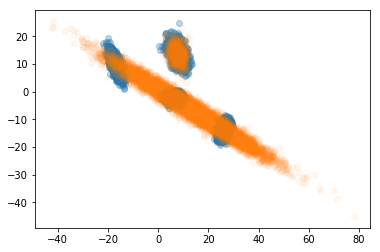

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 59101.640625
  Number of iterations: 50
  Number of functions evaluations: 69
59101.64
5.869968
5.8708134


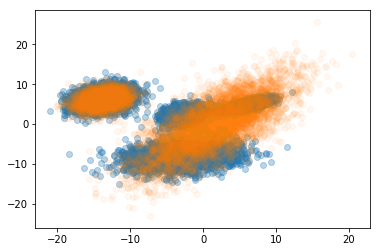

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 47536.628906
  Number of iterations: 104
  Number of functions evaluations: 141
47536.63
4.6608133
4.6858664


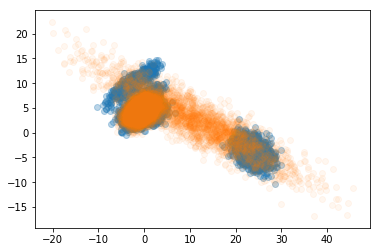

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 52940.769531
  Number of iterations: 53
  Number of functions evaluations: 75
52940.77
5.285179
5.2576647


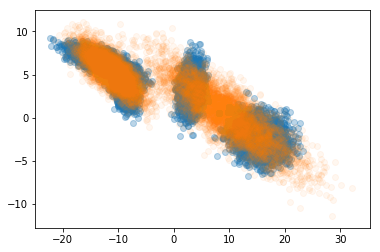

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62120.742188
  Number of iterations: 111
  Number of functions evaluations: 139
62120.742
6.0775023
6.09785


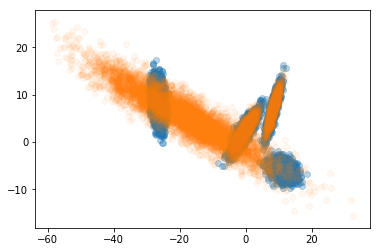

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 67380.335938
  Number of iterations: 36
  Number of functions evaluations: 45
67380.336
6.6310782
6.6294312


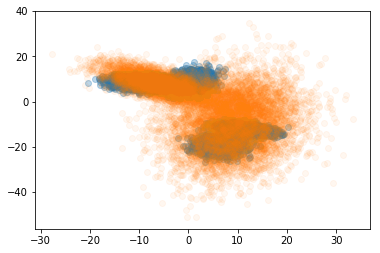

In [5]:
models = []
models.append(Mapper(mixtureOfGaussians, 'mog', observed_variable_names=['data'], n_observations=N, n_components=n_components, n_features=n_features, mixture_component_covariances_cholesky_scale_tril= mixture_component_covariances_cholesky_scale_tril))        
model_names = [model.model_name for model in models]

test_models = [mixtureOfGaussiansTest]
train_neg_log_lik_op = []
test_neg_log_lik_op = []
data_train = tf.placeholder(shape=(N,n_features), dtype='float32') 
data_test = tf.placeholder(shape=(Ntest,n_features), dtype='float32')
for model, test_model in zip(models, test_models):
    train_neg_log_lik_op.append(neg_log_lik(model.variables,test_model,data_train))
    test_neg_log_lik_op.append(neg_log_lik(model.variables,test_model,data_test))
placeholder_deviation = tf.placeholder(dtype='float32')
with tape() as reference_tf:
    data_tf = mixtureOfGaussians(n_observations=N + Ntest, n_components=4, n_features=n_features, mixture_component_means_std=placeholder_deviation)
        
with tf.Session() as sess:
    for _ in range(10):
        data, reference = sess.run([data_tf, reference_tf], feed_dict={placeholder_deviation: deviation})
        loss = {}
        opt = {}
        for i,model in enumerate(models): 
            loss[model.model_name], opt[model.model_name] = model.map_optimizer(data=data[:N])
            sess.run(tf.global_variables_initializer())
            opt[model.model_name].minimize()
            MAP_parameter, converged_loss = sess.run([model.variables, loss[model.model_name]])
            print(converged_loss)
            print(sess.run(train_neg_log_lik_op[i], feed_dict={data_train: data[N:]}))
            print(sess.run(test_neg_log_lik_op[i], feed_dict={data_test: data[:N]}))
            mapmog = MAP_model(MAP_parameter,mixtureOfGaussiansTest,Ntest)
            plt.scatter(*data[Ntest:].T,alpha=.3)
            plt.scatter(*mapmog.distribution.sample(Ntest).eval().T,alpha=.06)
            plt.show()